## Статистичний аналіз числових полів у FactFlight

Імпортуємо необхідні бібліотеки

In [9]:
from utils.spark_utils import create_spark_session
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, mean, stddev, min, max, expr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Створюємо Spark сесію та завантажуємо таблицю FactFlight

In [3]:
spark = create_spark_session()
fact_flight = spark.read.csv("../output/FactFlight.csv", header=True, inferSchema=True)
fact_flight.printSchema()

root
 |-- flight_id: string (nullable = true)
 |-- date_id: string (nullable = true)
 |-- departure_time_id: string (nullable = true)
 |-- arrival_time_id: string (nullable = true)
 |-- origin_airport_id: string (nullable = true)
 |-- destination_airport_id: string (nullable = true)
 |-- marketing_airline_id: string (nullable = true)
 |-- operating_airline_id: string (nullable = true)
 |-- tail_number: string (nullable = true)
 |-- dep_delay_minutes: double (nullable = true)
 |-- arr_delay_minutes: double (nullable = true)
 |-- crs_elapsed_time: double (nullable = true)
 |-- actual_elapsed_time: double (nullable = true)
 |-- distance: double (nullable = true)
 |-- status: string (nullable = true)
 |-- flight_complexity_score: double (nullable = true)



In [4]:
fact_flight.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+-----------+-----------------+-----------------+----------------+-------------------+--------+-------+-----------------------+
|           flight_id|             date_id|   departure_time_id|     arrival_time_id|   origin_airport_id|destination_airport_id|marketing_airline_id|operating_airline_id|tail_number|dep_delay_minutes|arr_delay_minutes|crs_elapsed_time|actual_elapsed_time|distance| status|flight_complexity_score|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+-----------+-----------------+-----------------+----------------+-------------------+--------+-------+-----------------------+
|ea69ecc1-8dc5-4a9...|38f82f5b-e0e6-449...|39695764-0f58-4aa...|678f28b7-853e-423...|71d56254-5e12-443...|

Числовими колонками, які нас цікавлять, є:
- dep_delay_minutes
- arr_delay_minutes
- crs_elapsed_time
- distance
- actual_elapsed_time
- flight_complexity_score

Обчислимо описову статистику (mean, median, std, min, max) цих полів

In [49]:
def describe_numeric_fields(fact_df: DataFrame):
    numeric_cols = [
        "dep_delay_minutes",
        "arr_delay_minutes",
        "distance",
        "actual_elapsed_time",
        "flight_complexity_score"
    ]

    results = []

    for c in numeric_cols:
        stats = (
            fact_df.select(
                mean(col(c)).alias("mean"),
                expr(f"percentile_approx({c}, 0.5)").alias("median"),
                stddev(col(c)).alias("std"),
                min(col(c)).alias("min"),
                max(col(c)).alias("max")
            ).collect()[0]
        )

        row = {
            "column": c,
            "mean": stats["mean"],
            "median": stats["median"],
            "std": stats["std"],
            "min": stats["min"],
            "max": stats["max"]
        }
        results.append(row)

    pdf = pd.DataFrame(results)
    print(pdf)

In [50]:
describe_numeric_fields(fact_flight)

                    column        mean      median         std          min  \
0        dep_delay_minutes   12.784776    0.000000   46.176242     0.000000   
1        arr_delay_minutes   12.812121    0.000000   45.803033     0.000000   
2                 distance  779.656762  626.000000  581.184744    16.000000   
3      actual_elapsed_time  133.283632  116.000000   70.768572 -1228.000000   
4  flight_complexity_score    1.684112    1.239192    1.809821     0.025749   

           max  
0  7223.000000  
1  7232.000000  
2  5812.000000  
3  1604.000000  
4   241.542369  


Більшість рейсів виконуються вчасно, оскільки медіани затримок вильоту та прибуття дорівнюють нулю.
**Середні затримки близько 13 хвилин** свідчать про наявність окремих рейсів з великими відхиленнями.
Максимальні затримки понад 7000 хвилин є аномальними і потребують перевірки даних.
Середня відстань польоту становить приблизно **780 миль**, що характерно для середньої дальності маршрутів.
Тривалість рейсів у середньому дорівнює **133 хвилинам**, але наявність негативних значень вказує на можливі помилки у записах.
Показник складності рейсу варіюється доволі сильно, що може відображати різні операційні умови польотів.

Далі проведемо аналіз і візуалізацію розподілів затримок

In [7]:
def delay_distributions(fact_df: DataFrame, sample_fraction=0.7):
    for c in ["dep_delay_minutes", "arr_delay_minutes", "flight_complexity_score", "distance", "actual_elapsed_time"]:
        print(f"\nГістограма для {c}")

        df_sample = (fact_df
                     .select(col(c).cast("double").alias(c))
                     .na.drop(subset=[c])
                     .sample(withReplacement=False, fraction=sample_fraction, seed=42))

        values = df_sample.toPandas()[c]

        plt.figure(figsize=(9, 4))
        plt.hist(values, bins=40)
        plt.title(f"Розподіл {c}")
        plt.xlabel("Затримка, хв")
        plt.ylabel("К-ть рейсів")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.show()


        quantiles = [0.25, 0.5, 0.75, 0.95, 0.99]
        qs = fact_df.approxQuantile(c, quantiles, 0.01)
        print(f"Квантилі {c}:")
        for q, v in zip(quantiles, qs):
            print(f"  {int(q*100)}%: {v}")



Гістограма для dep_delay_minutes


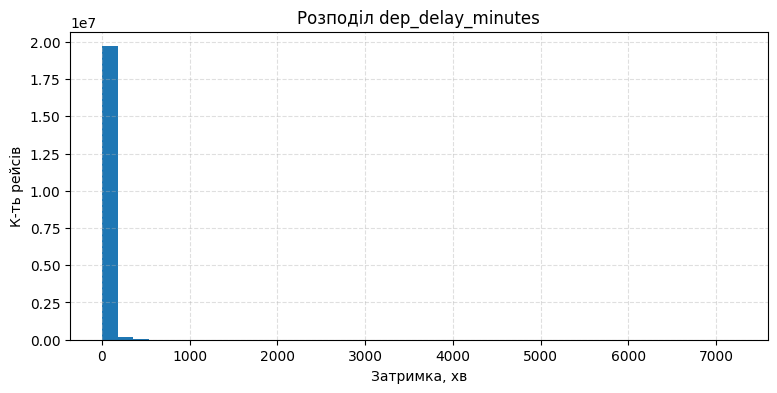

Квантилі dep_delay_minutes:
  25%: 0.0
  50%: 0.0
  75%: 5.0
  95%: 65.0
  99%: 7223.0

Гістограма для arr_delay_minutes


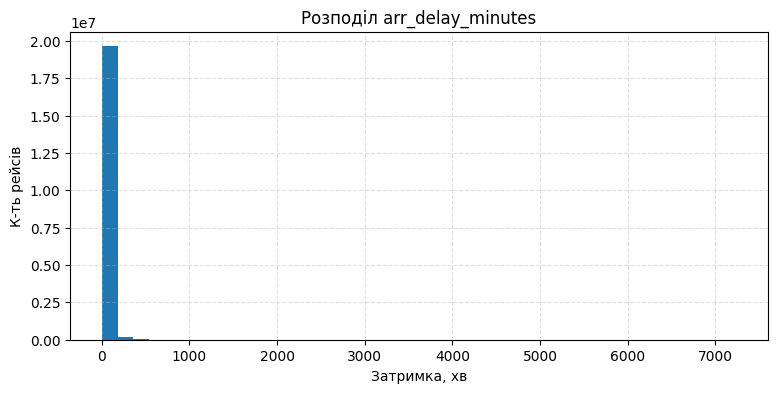

Квантилі arr_delay_minutes:
  25%: 0.0
  50%: 0.0
  75%: 6.0
  95%: 65.0
  99%: 7232.0

Гістограма для flight_complexity_score


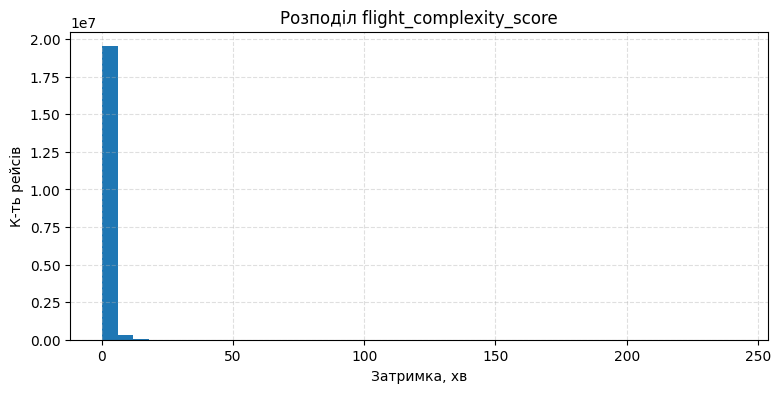

Квантилі flight_complexity_score:
  25%: 0.66948544
  50%: 1.22953576
  75%: 2.05351784
  95%: 4.196454026666666
  99%: 241.5423685466667

Гістограма для distance


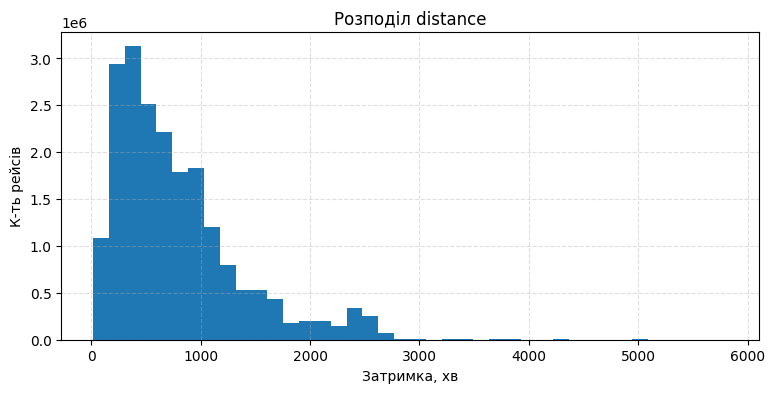

Квантилі distance:
  25%: 353.0
  50%: 623.0
  75%: 1011.0
  95%: 1984.0
  99%: 5812.0

Гістограма для actual_elapsed_time


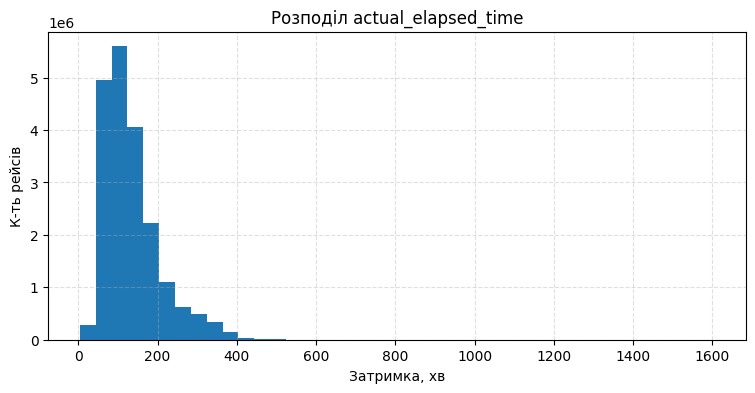

Квантилі actual_elapsed_time:
  25%: 82.0
  50%: 116.0
  75%: 163.0
  95%: 279.0
  99%: 1604.0


In [8]:
delay_distributions(fact_flight)

- Більшість рейсів мають нульову або мінімальну **затримку вильоту**, що свідчить про високу пунктуальність авіакомпаній. Медіана дорівнює нулю, отже понад половина рейсів вилітає вчасно або навіть раніше запланованого часу. Три чверті рейсів мають затримку не більше п’яти хвилин, що є допустимим і операційно стабільним показником. Лише близько 5% рейсів мають затримку понад годину, що вважається суттєвим відхиленням від розкладу. Значення у 7223 хвилини є аномалією — ймовірно, результатом технічної помилки або скасованого рейсу.

- Більшість рейсів прибувають без значної **затримки прибуття**, що підтверджується медіаною, рівною нулю. Понад половина літаків завершує політ вчасно або навіть раніше запланованого часу. Три чверті рейсів мають затримку не більше шести хвилин, що говорить про ефективне управління польотами та дотримання розкладу. Лише близько 5% рейсів прибувають із запізненням понад годину, а більшість випадків затримок залишаються незначними. Випадки із затримками понад 7232 хвилини вказують на помилки у даних або надзвичайні ситуації, що формують правий “хвіст” у розподілі.

- Розподіл **flight_complexity_score** показує, що більшість рейсів мають низький рівень складності польоту. Перший квартиль становить близько 0.67, а медіана — 1.23, тобто понад половина рейсів характеризується простою структурою маршруту без значних затримок чи великих відстаней. Три чверті рейсів мають показник складності нижче 2.05, що свідчить про відносно стандартні умови виконання польотів. Лише 5% рейсів мають complexity score вище 4.19 — це, ймовірно, далекі або проблемні рейси з помітними затримками. Водночас значення 241.54 є екстремальним викидом, що може бути спричинене помилками у даних або надзвичайними випадками, як-от технічні несправності чи форс-мажорні обставини.

- Розподіл **distance** демонструє, що більшість польотів відбуваються на короткі або середні дистанції. Перший квартиль дорівнює приблизно 353 км, а медіана — 623 км, що вказує на переважання внутрішніх або регіональних рейсів. Три чверті рейсів мають довжину маршруту менше 1011 км, тоді як лише 5% перевищують 1984 км, тобто належать до міжрегіональних або міжконтинентальних перельотів. Значення 5812 км у 99-му перцентилі свідчить про наявність кількох наддалеких рейсів, які істотно впливають на “хвіст” розподілу. Загальна форма гістограми має чіткий правий перекіс, що є типовим для авіаперевезень, де короткі рейси значно переважають над довгими.

Далі буде обчислено кореляції між затримками, відстанню та складністю рейсу

In [12]:
def correlation_analysis(fact_df: DataFrame):
    cols = [
        "dep_delay_minutes",
        "arr_delay_minutes",
        "distance",
        "actual_elapsed_time",
        "flight_complexity_score"
    ]

    pdf = fact_df.select(cols).sample(fraction=0.8, seed=42).toPandas()

    corr_matrix = pdf.corr(method='pearson')

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        square=True
    )
    plt.title("Correlation Matrix Heatmap")
    plt.tight_layout()
    plt.show()

    print("\nКореляційна матриця:")
    print(corr_matrix)


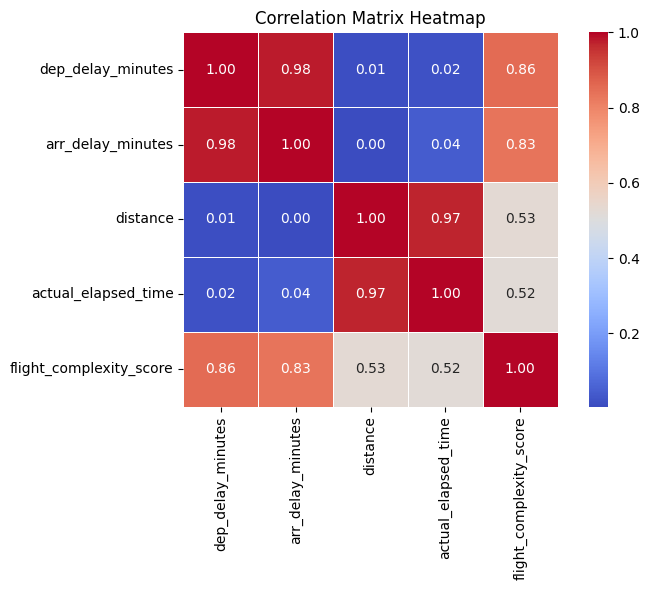


Кореляційна матриця:
                         dep_delay_minutes  arr_delay_minutes  distance  \
dep_delay_minutes                 1.000000           0.979061  0.009228   
arr_delay_minutes                 0.979061           1.000000  0.004931   
distance                          0.009228           0.004931  1.000000   
actual_elapsed_time               0.017744           0.043221  0.968943   
flight_complexity_score           0.855253           0.834476  0.526081   

                         actual_elapsed_time  flight_complexity_score  
dep_delay_minutes                   0.017744                 0.855253  
arr_delay_minutes                   0.043221                 0.834476  
distance                            0.968943                 0.526081  
actual_elapsed_time                 1.000000                 0.518549  
flight_complexity_score             0.518549                 1.000000  


In [13]:
correlation_analysis(fact_flight)

Найсильніший зв’язок спостерігається між затримками вильоту та прибуття (0.98), що логічно — запізнення при старті майже завжди тягне за собою пізніше прибуття. Також простежується висока кореляція між відстанню та фактичним часом у польоті (0.97), адже чим довший маршрут, тим більше часу триває переліт. Показник flight_complexity_score має суттєвий зв’язок як із затримками (0.83–0.86), так і з тривалістю рейсу (≈0.52), що вказує на зростання складності у разі довгих або проблемних польотів. Отже, теплова карта демонструє дві групи взаємопов’язаних факторів — часові затримки та параметри маршруту, які спільно впливають на загальну ефективність рейсів.